In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnosti

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    #print("left or right image not receieved")
    time.sleep(0.5)
    
print("left or right image receieved")

left or right image receieved


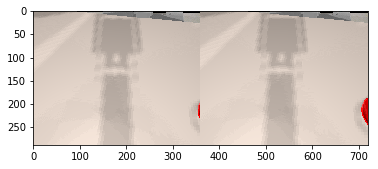

In [4]:
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 10177
  stamp: 
    secs: 1620783612
    nsecs: 226765156
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 10177
  stamp: 
    secs: 1620783612
    nsecs: 226765156
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0


In [6]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, psm2, psm3, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')
    psm3 = dvrk.psm('PSM3')
    
    psm1_suj = dvrk.suj('PSM1')
    psm2_suj = dvrk.suj('PSM2')
    psm3_suj = dvrk.suj('PSM3')
    ecm_suj = dvrk.suj('ECM')
    
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [7]:
tf_listener = tf.TransformListener()
time.sleep(5)

In [8]:
tf_listener.getFrameStrings()

/home/iandre/dvrk_ws/src/geometry/tf/src/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_tool_wrist_shaft_link',
 'PSM3_outer_pitch_bottom_link',
 'PSM1_RCM',
 'PSM3_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_outer_insertion_link',
 'PSM1_tool_wrist_sca_ee_link_0',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_tool_wrist_sca_ee_link_2',
 'PSM2_outer_pitch_bottom_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM3_tool_wrist_link',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'camera',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM2_RCM',
 'PSM2_tool_wrist_caudier_link',
 'PSM3_tool_wrist_caudier_link_2_right',
 'ecm_pitch_link_1',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'PSM3_tool_wrist_caudier_link_2_left',
 'PSM3_outer_pitch_back_link',
 'PSM1_outer_pitch_top_link',
 'Vision_sensor_left',
 'simworld',
 'PSM2_tool_wrist_caudier_link_2_right',
 'ecm_base_link',
 'PSM1_tool_wrist_link',
 'PSM1_tool_main_link',
 'PSM3_tool_wrist_caudier_ee_link_0',
 'PSM2_tool_wrist_link',
 'Jp21_ECM'

In [9]:
from math import radians as r

# 2 arm setup
# sm1 = [0.5, -2.4958207607269287, 2.775073528289795, 0.13962633907794952, -0.5235987901687622]
# sm2 = [0.5, 2.6005406379699707, -2.7227137088775635, -0.20943951606750488, -0.7155849933624268]
# cm = [1.0, -1.2042771577835083, 2.687807083129883, -1.4311699867248535]

# 3 arm setup
# height, shoulder, elbow, wrist, rotate
sm1 = [-0.0, -1.3, 1.9, -0.1, -0.8]  # right
sm2 = [-0.0, 1.3, -1.8, -0.2, -0.8]  #  left
sm3 = [0.35, 2.1, -1.8, -1.0, -1.4]  # middle
cm = [0.52, 0.7, -1.6, 0.9]
time.sleep(1)

psm1_suj.move_joint(np.asarray(sm1))
psm2_suj.move_joint(np.asarray(sm2))
psm3_suj.move_joint(np.asarray(sm3))
ecm_suj.move_joint(np.asarray(cm))

print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
print(psm1_suj.get_current_position())
print(psm2_suj.get_current_position())
print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

[-0.         -1.29999995  1.89999998 -0.1        -0.80000001]
[-0.          1.29999995 -1.79999995 -0.2        -0.80000001]
[ 0.34999999  2.0999999  -1.79999995 -1.         -1.39999998]
[ 0.51999998  0.69999999 -1.60000002  0.89999998]
----------------------------------
[[ 3.33067e-16,          -1,           0;
            1, 3.33067e-16,           0;
            0,           0,           1]
[     -1.9501,   -0.101602,      0.9088]]
[[ 3.33067e-16,           1,           0;
           -1, 3.33067e-16,          -0;
           -0,           0,           1]
[      1.9501,   -0.101598,      0.9088]]
[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[-1.50197e-06,      2.0009,      0.9163]]
[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]


In [10]:
# 3 arm setup
# ecm: rotate, up/down, zoom, rotate view
HARDCODED_ECM_POS = np.array([-0.35, -0.3, 0.15, 0.0])
PSM_HOME_POS = np.asarray([0.0, 0.2, 0.05, 0.0, 0.0, 0.0])
# 2 arm setup
# HARDCODED_ECM_POS = np.array([0.0, 0.0, 0.0, 0.0])
# PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
time.sleep(1)

psm1.move_joint(deepcopy(PSM_HOME_POS))
psm1.close_jaw()
time.sleep(1)

psm2.move_joint(deepcopy(PSM_HOME_POS))
psm2.close_jaw()
time.sleep(1)

psm3.move_joint(deepcopy(PSM_HOME_POS))
psm3.close_jaw()
time.sleep(1)

ecm.move_joint(HARDCODED_ECM_POS)

True

In [11]:
pick_and_place_utils = None
from pick_and_place_utils import get_objects_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF, World
import image_geometry

time.sleep(1)
tf_cam_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))

tf_world_to_psm1 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
tf_world_to_psm3 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM3_base', 'simworld', rospy.Time()))

tf_world_to_psm1_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'world', rospy.Time()))
tf_world_to_psm1_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm1_j1

tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'world', rospy.Time()))
tf_world_to_psm2_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1

tf_world_to_psm3_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM3', 'world', rospy.Time()))
tf_world_to_psm3_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm3_j1

tf_cam_to_world

[[   0.0393343,    0.966197,    0.254786;
     0.955624,   0.0381257,    -0.29211;
     -0.29195,     0.25497,   -0.921822]
[    -1.01455,   0.0348027,     1.22508]]

In [12]:
stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)

objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, 
                                          cam_to_world_tf=tf_cam_to_world)
world = World(objects)
world

<World objects: [<Object3d pos: [   -0.979471,   -0.105425,     1.03748] type: FeatureType.BALL color: 2>, <Object3d pos: [   -0.994795,  -0.0167731,     1.03537] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.00743,  -0.0602051,     1.04564] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.02608,   -0.116124,     1.02799] type: FeatureType.BALL color: 0>, <Object3d pos: [    -1.02001,   0.0156114,     1.04164] type: FeatureType.BALL color: 0>, <Object3d pos: [    -1.03739,  -0.0290678,     1.05099] type: FeatureType.BALL color: 1>]
bowl: <Object3d pos: [   -0.908673,  -0.0336488,     1.06452] type: FeatureType.BOWL color: 0>>

In [13]:
len(objects)

7

[   -0.908673,  -0.0336488,     1.06452]


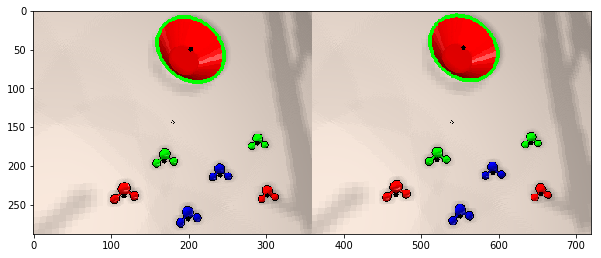

In [14]:
ball_pos_cam = objects[0].pos
print(ball_pos_cam)

plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [15]:
from pick_and_place_arm_sm import PickAndPlaceStateMachine, PickAndPlaceState
from pick_and_place_hsm import PickAndPlaceHSM
from pick_and_place_dual_arm_sm import PickAndPlaceDualArmStateMachine
import IPython
from timeit import default_timer as timer
from pick_and_place_utils import get_objects_for_psms
from enum import Enum
the_image = IPython.display.Image(frame)

objects_to_pick = deepcopy(world.objects)

# this vector is empirically determined
#approach_vec = PyKDL.Vector(0.007, 0.0, -0.015)
approach_vec = PyKDL.Vector(0.000, 0.00, -0.000)

In [ ]:
start_time = time.time()

class TaskType(Enum):
    OneArmFSM = 0
    TwoArmFSM = 1
    TwoIndependentFSM = 2
    HCFSM = 3

    
# change this line to change which task is run
task_type = TaskType.OneArmFSM


start_time = time.time()
if task_type == TaskType.OneArmFSM:
    # ========================================================================================================== 
    # Runs 1 FSM
    # ========================================================================================================== 
    sm = PickAndPlaceStateMachine(psm3, world, tf_world_to_psm3_base, None, approach_vec, closed_loop=True,
                                  log_verbose=True)

    while not (sm.is_done() or sm.state == PickAndPlaceState.HOME):
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        sm.update_world(world)
        sm.run_once()
        
elif task_type == TaskType.TwoArmFSM:
    # ========================================================================================================== 
    # This runs the single FSM that runs both arms sequentially
    # ========================================================================================================== 
    sm = PickAndPlaceDualArmStateMachine([psm1, psm2], [tf_world_to_psm1_base, tf_world_to_psm2_base], world, 
                                        approach_vec)
    
    while not sm.is_done():
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        sm.update_world(world)
        sm.run_once()
        
elif task_type == TaskType.TwoIndependentFSM:
    # ========================================================================================================== 
    # Runs 2 independent FSMs, one for each arm
    # ========================================================================================================== 

    objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
    world = World(objects)
    original_bowl = world.bowl

    # assign objects to PSM1/PSM2 state machines
    psm_object_dict = get_objects_for_psms(world.objects, [tf_world_to_psm1_base, tf_world_to_psm2_base])


    psm1_sm = PickAndPlaceStateMachine(psm1, world, tf_world_to_psm1_base, None, approach_vec,
                                      closed_loop=True, pick_closest_to_base_frame=True)

    psm2_sm = PickAndPlaceStateMachine(psm2, world, tf_world_to_psm2_base, None, approach_vec,
                                      closed_loop=True, pick_closest_to_base_frame=True)

    # because we exit out of the loop as soon as both arms are in the HOME state 
    # (i.e. they have began to move to the home position), the end time is exactly the first 'tick' after
    # the last arm has opened its gripper past 60 degrees
    while (psm1_sm.state != PickAndPlaceState.HOME) or (psm2_sm.state != PickAndPlaceState.HOME):
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        psm1_sm.update_world(world)
        psm2_sm.update_world(world)
        psm1_sm.run_once()
        psm2_sm.run_once()
elif task_type == TaskType.HCFSM:
    # ========================================================================================================== 
    # This runs the hierarchical concurrent state machine that runs both arms concurrently
    # ========================================================================================================== 
    hsm = PickAndPlaceHSM([psm1, psm2], [tf_world_to_psm1_base, tf_world_to_psm2_base], world, approach_vec, 
                          log_verbose=False)

    while not hsm.is_done():
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        hsm.update_world(world)
        hsm.run_once()

[INFO] [1620783660.949645]: PickAndPlaceStateMachine:__init__
[INFO] [1620783660.983381]: psm: PSM3, world: <World objects: [<Object3d pos: [   -0.979471,   -0.105425,     1.03748] type: FeatureType.BALL color: 2>, <Object3d pos: [   -0.994795,  -0.0167731,     1.03537] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.00743,  -0.0602051,     1.04564] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.02608,   -0.116124,     1.02799] type: FeatureType.BALL color: 0>, <Object3d pos: [    -1.02001,   0.0156114,     1.04164] type: FeatureType.BALL color: 0>, <Object3d pos: [    -1.03739,  -0.0290678,     1.05099] type: FeatureType.BALL color: 1>]
bowl: <Object3d pos: [   -0.908673,  -0.0336488,     1.06452] type: FeatureType.BOWL color: 0>>, world_to_psm_tf: [[  0.00104398,    0.905138,    0.425117;
    -0.999999,  0.00146826,-0.000670414;
    -0.001231,   -0.425116,    0.905138]
[   -0.410899,    -1.03675,    -1.17227]], object: None
[INFO] [1620783661.011430]: home_when_don

[INFO] [1620783676.649894]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783676.679780]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783677.140140]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783677.171319]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783677.374126]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783677.404361]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783677.548509]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783677.733720]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783677.953198]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783678.192766]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783678.384384]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783678.391213]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783678.630522]: Running state PickAndPlaceState.AP

[INFO] [1620783695.070631]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783695.097623]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783695.203551]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783695.224332]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783695.393390]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783695.539990]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783695.758129]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783695.868485]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783696.007204]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783696.188638]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783696.360719]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783696.374447]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783696.586215]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [162078

[INFO] [1620783712.174088]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783712.205955]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783712.485690]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783712.494687]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783712.775892]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783712.794542]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783713.069701]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783713.087940]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783713.318175]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783713.487234]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783713.810151]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783714.246538]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783714.475576]: Running state PickAndPlaceState.

[INFO] [1620783729.057349]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783729.207198]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783729.347764]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783729.493211]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783729.762879]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783730.195007]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783730.222189]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783730.343203]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783730.377341]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783730.507543]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783730.539218]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783730.753413]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783730.790215]: Setting PSM3 dest to [   0.0130327,  -

[INFO] [1620783745.098615]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783745.432675]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783745.565014]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783745.576274]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783745.879922]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783745.924877]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783746.213283]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783746.281170]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783746.555831]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783746.686042]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783746.819450]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783747.421848]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783747.709277]: Running state PickAndPlaceState.APPROACH_OBJECT
[INF

[INFO] [1620783762.896406]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783763.051611]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783763.247357]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783763.425625]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783763.455967]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783763.695688]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783763.710851]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783763.879916]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783763.910665]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783764.062348]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783764.087334]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783764.365725]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783764.419098]: Setting PSM3 dest to [   0.02299

[INFO] [1620783778.943049]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783778.968493]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783779.106772]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783779.117869]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783779.547049]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783779.848525]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783780.020280]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783780.123435]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783780.247080]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783780.408955]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783780.454096]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783780.589081]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783780.601818]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620783791.009258]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783791.137667]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783791.274949]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783791.400304]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783791.722528]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783791.763899]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783792.043598]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783792.067817]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783792.253035]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783792.284548]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783792.631698]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783792.646653]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783792.739033]: Running state PickAndPlaceState.DROP

[INFO] [1620783803.267653]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783803.364165]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783803.525719]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783803.744015]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783803.814272]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783803.825025]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783803.948236]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783803.979546]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783804.143737]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783804.158869]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783804.307612]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783804.318693]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783804.423519]: Running state PickAn

[INFO] [1620783814.564619]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783814.580360]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783814.674376]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783814.683562]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783814.826009]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783814.854995]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783814.979156]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783814.996534]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783815.106814]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783815.120395]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783815.231159]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783815.332838]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783815.649253]: Runnin

[INFO] [1620783824.338253]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783824.450430]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783824.591240]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783824.643783]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783824.671393]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783824.826269]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783824.861356]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783824.890615]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783824.918980]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783825.079812]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783825.087879]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783825.168432]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783825.171319]: Setting PSM3 des

[INFO] [1620783833.866920]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783833.879112]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783833.957820]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783833.982972]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783834.137106]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.199220]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.249205]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.307731]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.515238]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.634332]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.706956]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783834.909399]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783834.925373]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[I

[INFO] [1620783843.642660]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783843.652098]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783843.793614]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783843.822885]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783844.125381]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783844.128213]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783844.217988]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783844.229094]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783844.323895]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783844.484279]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783844.604365]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783844.902409]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783844.992576]: Running state PickAndPlaceSt

[INFO] [1620783854.289754]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783854.307530]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783854.371985]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783854.465677]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783854.611898]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783854.714098]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783854.805761]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783854.966239]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783855.058390]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783855.070486]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783855.153645]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783855.171830]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783855.378215]: Running state PickAndPlaceState.APPROACH_OBJ

[INFO] [1620783864.237604]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783864.256490]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783864.377865]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783864.397869]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783864.487940]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783864.509117]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783864.587489]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783864.611386]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783864.886136]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783864.973806]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783865.180236]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783865.258248]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783865.355525]: Running state PickAndPlaceSt

[INFO] [1620783874.701791]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783874.906697]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783874.919210]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783875.029537]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783875.049730]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783875.215434]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783875.230349]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783875.377399]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783875.472115]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783875.609878]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783875.724790]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783875.862346]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783876.006660]: Running state PickAndPlaceStat

[INFO] [1620783885.190016]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783885.199532]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783885.270446]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783885.278349]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783885.455526]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783885.482399]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783885.584512]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783885.594986]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783885.844031]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783885.864844]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783885.940233]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783886.067902]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783886.129159]: Running 

[INFO] [1620783894.761658]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783894.956670]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783895.163750]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783895.284871]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783895.311652]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783895.461032]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783895.501859]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783895.689734]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783895.714707]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783895.849326]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783895.874096]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783895.985435]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783896.012656]: Setting PSM3 dest to [   0.02299

[INFO] [1620783904.930401]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783905.057818]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783905.171585]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783905.323149]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783905.513015]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783905.533946]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783905.592232]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783905.637225]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783905.714742]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783905.739026]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783905.950688]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783905.962322]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783906.153100]: Running state PickAndPlaceState.APPR

[INFO] [1620783914.384385]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783914.396650]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783914.463617]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783914.588026]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783914.669056]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783914.857920]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783914.975554]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783915.053979]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783915.070545]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783915.194669]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783915.224476]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783915.356929]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783915.377511]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.1661

[INFO] [1620783924.173237]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783924.208495]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783924.345081]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783924.360775]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783924.422993]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783924.461181]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783924.620381]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620783924.639556]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783924.819533]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783924.902384]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783925.090816]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783925.226774]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620783925.407202]: Running state PickAndPlaceState.

[INFO] [1620783934.080704]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783934.310868]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783934.470547]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783934.493441]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783934.622499]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783934.633525]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783934.789006]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783934.801231]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783934.929483]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783934.936297]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783935.021968]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783935.031877]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783935.114993]

[INFO] [1620783943.915293]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783943.937906]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783944.072297]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783944.092995]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783944.285873]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783944.294681]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783944.481236]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783944.686874]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783944.836341]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783945.028715]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783945.139503]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783945.150135]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783945.310557]: Running state PickAndPlace

[INFO] [1620783954.222069]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783954.239254]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783954.391588]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783954.412447]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783954.578204]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783954.588750]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783954.706622]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783954.918720]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783955.075080]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783955.162476]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783955.289413]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783955.435654]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783955.460199]: Setting PSM3 dest to [   0.0130327,  -0.0426

[INFO] [1620783964.406909]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783964.419185]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783964.599464]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783964.616864]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783964.762745]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783964.876991]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783965.032403]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783965.431382]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783965.552297]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783965.570001]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783965.677806]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783965.696601]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620783965.882231]: Running state PickAndPla

[INFO] [1620783974.233770]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783974.251186]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783974.424410]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783974.459336]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783974.632978]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783974.659039]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783974.775437]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783974.878243]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783974.995710]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783975.105039]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783975.363490]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783975.478685]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620783975.487836]: Setting PSM3 dest to [   0.0130327,  -0.0426

[INFO] [1620783984.535952]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783984.557260]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783984.691152]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783984.708039]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783984.932827]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783984.963244]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783985.081738]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783985.103692]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783985.193842]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783985.267883]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783985.384832]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783985.526829]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783985.681518]: Running state PickAndPlaceSt

[INFO] [1620783994.512827]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783994.543687]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783994.716736]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783994.735121]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783994.925876]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783994.948585]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783995.077879]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783995.100964]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783995.288929]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620783995.301700]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620783995.450924]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783995.604555]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620783995.736191]: Running 

[INFO] [1620784004.462232]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784004.493795]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784004.740478]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784004.818765]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784004.996180]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784005.005658]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784005.132790]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784005.226079]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784005.437151]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784005.558343]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784005.672873]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784005.782335]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784005.792571]: Setting PSM3 dest to [   0.0130327,  -0.0426

[INFO] [1620784014.470841]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784014.479651]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784014.650951]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784014.678567]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784014.806990]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784014.822522]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784014.967121]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784014.974390]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784015.104148]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784015.116616]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784015.214475]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784015.395386]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784015.559876]: Running 

[INFO] [1620784024.206800]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784024.356718]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784024.496969]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784024.516855]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784024.671835]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784024.691340]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784024.933272]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784024.953276]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784025.065747]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784025.083452]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784025.226753]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784025.245646]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784025.395926]: Running stat

[INFO] [1620784034.020674]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784034.173203]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784034.341837]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784034.508383]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784034.677918]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784034.825934]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784034.833727]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784034.948591]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784034.981868]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784035.107254]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784035.116099]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784035.201849]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784035.219888]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620784044.886513]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784045.013677]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784045.154165]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784045.329796]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784045.518129]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784045.679145]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784045.692507]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784045.851795]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784045.892927]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784046.027366]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784046.030817]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784046.146204]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784046.165498]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620784055.797598]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784056.051052]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784056.173250]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784056.253081]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784056.420118]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784056.498029]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784056.654079]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784056.895240]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784056.916160]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784057.074917]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784057.099157]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784057.241820]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784057.262965]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155

[INFO] [1620784068.104309]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784068.226104]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784068.458555]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784068.585231]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784068.609495]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784068.797997]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784068.822947]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784068.914210]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784068.918545]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784069.014929]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784069.034562]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784069.126930]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784069.146130]: Setting PSM3 dest to [   0.02299

[INFO] [1620784078.376581]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784078.483342]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784078.661840]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784078.959821]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784079.000296]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784079.137860]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784079.156178]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784079.281298]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784079.291616]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784079.372562]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784079.409469]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784079.611199]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784079.643274]: Setting PSM3 dest to [   0.02299

[INFO] [1620784091.929732]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784092.132971]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784092.317978]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784092.334857]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784092.429773]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784092.459036]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784092.760401]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784092.772148]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784092.961693]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784092.973637]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784093.205512]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784093.229928]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784093.406183]: Running stat

[INFO] [1620784103.889297]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784104.025071]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784104.035505]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784104.129873]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784104.161008]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784104.411436]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784104.420066]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784104.507259]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784104.529699]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784104.620944]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784104.677292]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784104.787188]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784104.808836]: Setting 

[INFO] [1620784115.021560]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784115.202176]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784115.472876]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784115.543108]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784115.689701]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784115.875297]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784115.896582]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784116.016153]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784116.035989]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784116.171364]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784116.182959]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784116.394439]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784116.406604]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620784126.312293]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784126.454848]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784126.693405]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784126.854673]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784126.876346]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784126.983866]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784127.016425]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784127.197905]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784127.225725]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784127.451992]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784127.480500]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784127.534977]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784127.544289]: Setting PSM3 dest to [   0.02299

[INFO] [1620784137.746781]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784137.937456]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784138.126041]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784138.298523]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784138.308101]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784138.418139]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784138.429822]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784138.567602]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784138.584075]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784138.643913]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784138.672805]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784138.811113]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784138.821469]: Setting PSM3 dest to [   0.02299

[INFO] [1620784148.966836]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784149.179557]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784149.361045]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784149.371501]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784149.468737]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784149.500579]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784149.662734]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784149.684286]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784149.773737]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784149.783498]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784149.915945]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784149.944342]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784150.028037]: Running stat

[INFO] [1620784159.209243]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784159.359823]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784159.571895]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784159.670402]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784159.922315]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784160.037816]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784160.046780]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784160.186817]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784160.198904]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784160.329771]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784160.365593]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784160.540116]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784160.551078]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620784170.838116]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784170.914080]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784171.044419]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784171.254831]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784171.281163]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784171.399807]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784171.418633]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784171.598865]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784171.611428]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784171.748477]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784171.778230]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784171.963504]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784171.986661]: Setting PSM3 dest to [   0.02299

[INFO] [1620784182.189171]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784182.368401]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784182.536541]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784182.774356]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784182.854093]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784182.888887]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784183.005847]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784183.016520]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784183.222598]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784183.238299]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784183.349714]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784183.380659]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784183.542268]: Running state PickAndPlaceState.APPR

[INFO] [1620784192.329615]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784192.354413]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784192.453348]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784192.474499]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784192.524137]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784192.673333]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784192.775428]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784192.873251]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784192.931142]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784193.044023]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784193.213750]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784193.232563]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784193.328902]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [162078

[INFO] [1620784201.769692]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784201.799635]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784201.902292]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784201.914817]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784201.965832]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784201.977662]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784202.116725]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784202.127895]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784202.496182]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784202.511838]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784202.594682]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784202.611865]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [

[INFO] [1620784211.689993]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784211.862618]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784211.974726]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784212.111288]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784212.230844]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784212.242908]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784212.472006]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784212.489982]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784212.682336]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784212.693560]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784212.885851]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784212.917924]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784212.996561]: Running state PickAn

[INFO] [1620784222.560739]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784222.580281]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784222.765321]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784222.783806]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784223.004046]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784223.033611]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784223.145328]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784223.150651]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784223.275398]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784223.516870]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784223.712200]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784223.789258]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784223.969144]: Running state PickAndPlaceState.

[INFO] [1620784233.240249]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784233.259039]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784233.351443]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784233.371595]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784233.516840]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784233.534418]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784233.677631]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784233.683200]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784233.830350]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784233.858108]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784234.038458]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784234.117315]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784234.228827]: Runnin

[INFO] [1620784244.475521]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784244.496891]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784244.756869]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784244.775941]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784244.987466]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784245.143917]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784245.235871]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784245.417893]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784245.517484]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784245.679244]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784245.700078]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784245.938628]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784245.951075]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620784255.515580]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784255.805667]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784255.979737]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784256.110748]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784256.129630]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784256.263881]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784256.279169]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784256.431829]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784256.454251]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784256.531320]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784256.548786]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784256.754032]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784256.764768]: Setting PSM3 dest to [   0.02299

[INFO] [1620784265.765573]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784265.782137]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784265.954466]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784266.157349]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784266.235652]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784266.300703]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784266.446596]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784266.568688]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784266.764647]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784266.787296]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784266.992042]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784267.003958]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784267.074456]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [16207842

[INFO] [1620784276.140394]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784276.161684]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784276.285425]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784276.331878]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784276.475763]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784276.620430]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784276.688950]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784276.882092]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784276.995118]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784277.007828]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784277.129040]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784277.145375]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784277.296225]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [16207842

[INFO] [1620784286.734585]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784286.767059]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784286.868396]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784286.898575]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784287.056979]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784287.069896]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784287.174423]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784287.316160]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784287.427019]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784287.650683]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784287.771956]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784287.828745]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784287.870292]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.

[INFO] [1620784297.738304]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784297.748789]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784297.863411]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784297.885438]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784298.152063]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784298.168551]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784298.388981]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784298.414744]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784298.537317]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784298.673926]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784298.712711]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784298.815701]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784299.012846]: Running state PickAndPlaceState.

[INFO] [1620784308.195603]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784308.357435]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784308.469819]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784308.607775]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784308.733386]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784308.828161]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784308.985538]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784309.003150]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784309.139720]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784309.150535]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784309.350981]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784309.359162]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784309.436184]: Running state PickAndPlaceState.APPROACH_O

[INFO] [1620784319.219190]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784319.375762]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784319.545130]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784319.632048]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784319.686132]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784319.721065]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784319.816346]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784319.835052]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784319.956026]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784319.965399]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784320.209398]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784320.234639]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784320.457531]: Running state PickAn

[INFO] [1620784330.038950]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784330.269708]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784330.458695]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784330.630894]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784330.783593]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784330.815459]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784330.974877]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784330.986012]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784331.100065]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784331.113603]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784331.288719]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784331.313185]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784331.445464]: Running state PickAn

[INFO] [1620784340.173057]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784340.204451]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784340.344781]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784340.352983]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784340.465035]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784340.475915]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784340.571670]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784340.651525]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784340.750031]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784340.862835]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784340.930370]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784341.128945]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784341.282836]: Running state PickAndPlaceState.APPROACH_OBJECT


[INFO] [1620784349.880280]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784350.048306]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784350.120529]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784350.152951]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784350.298122]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784350.316741]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784350.433405]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784350.448237]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784350.695581]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784350.705935]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784350.827355]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784350.855532]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784351.056845]: Running stat

[INFO] [1620784360.119360]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784360.212438]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784360.306702]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784360.496848]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784360.505034]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784360.679580]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784360.691307]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784360.757446]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784360.764783]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784360.903524]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784360.912469]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784361.058078]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784361.086528]: Setting PSM3 dest to [   0.02299

[INFO] [1620784370.847262]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784370.870732]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784370.963764]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784370.973517]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784371.155125]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784371.174588]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784371.339807]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784371.352995]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784371.556468]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784371.709147]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784371.830369]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784371.903178]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784371.959698]: Running state PickAndPlaceSt

[INFO] [1620784380.716009]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784380.897436]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784380.969791]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784380.982249]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784381.130502]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784381.148747]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784381.337770]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784381.354934]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784381.497996]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784381.506702]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784381.626592]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784381.663633]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784381.720631]: Running stat

[INFO] [1620784390.437787]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784390.619494]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784390.772427]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784390.859111]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784390.955640]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784391.113021]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784391.232834]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784391.253611]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784391.370534]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784391.398320]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784391.545140]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784391.571369]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784391.718385]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [162078

[INFO] [1620784400.433462]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784400.446704]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784400.571263]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784400.587956]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784400.842761]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784401.004645]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784401.204546]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784401.388909]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784401.475092]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784401.563984]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784401.582244]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784401.789008]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784401.825248]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.16

[INFO] [1620784412.031834]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784412.049604]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784412.200371]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784412.211010]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784412.275380]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784412.521496]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784412.697481]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784412.910390]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784412.962463]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784412.972062]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784413.159782]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784413.192829]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784413.295434]: Running state PickAndPlaceState.APPR

[INFO] [1620784422.912293]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784422.968962]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784423.074108]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784423.102176]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784423.240172]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784423.479094]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784423.628027]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784423.878915]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784424.060619]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784424.069879]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784424.161572]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784424.181579]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784424.304469]: Running state PickAndPlaceState.APPR

[INFO] [1620784433.724137]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784433.824566]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784433.844665]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784433.928410]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784434.033340]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784434.223204]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784434.404729]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784434.543840]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784434.674722]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784434.706002]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784434.767413]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784434.785802]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784434.968889]: Running state PickAndPlaceState.APPROACH_D

[INFO] [1620784443.790929]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784443.807884]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784443.991256]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784444.022747]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784444.162028]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784444.284834]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784444.507931]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784444.701364]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784444.849694]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784444.868575]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784444.981901]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784445.006486]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784445.129263]: Running state PickAndPlaceState.APPR

[INFO] [1620784454.835726]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784454.862461]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784455.051515]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784455.091091]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784455.204919]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.339113]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.405316]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.458454]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.591218]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.692294]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.753325]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784455.958064]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784455.976813]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784456

[INFO] [1620784465.463760]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784465.476888]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784465.560372]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784465.570173]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784465.731847]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784465.749397]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784465.879438]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784465.897720]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784466.065960]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784466.218690]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784466.303303]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784466.408352]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784466.477853]: Running state PickAndPlaceState.

[INFO] [1620784475.849069]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784475.858508]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784475.990373]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784476.017996]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784476.110701]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784476.126309]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784476.282486]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784476.306990]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784476.367087]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784476.521464]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784476.701125]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784476.870041]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1620784477.075248]: Running state PickAndPlaceState.

[INFO] [1620784486.262473]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784486.281982]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784486.399834]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784486.409825]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784486.506892]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784486.524300]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784486.670550]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784486.688424]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784486.860393]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784486.873725]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784487.015935]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1620784487.044133]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [

[INFO] [1620784496.115744]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784496.345455]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784496.424936]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784496.484604]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784496.623607]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784496.777644]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784496.937133]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784496.968937]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784497.058408]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784497.079106]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784497.251312]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784497.268576]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784497.429784]: Running state PickAndPlaceState.APPROACH_O

[INFO] [1620784506.771356]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1620784506.798490]: Setting PSM3 dest to [   0.0229939,   -0.128864,   -0.166155]
[INFO] [1620784507.034733]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784507.329178]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784507.484106]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784507.677139]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1620784507.760264]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784507.770468]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784508.131909]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784508.261477]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784508.458650]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1620784508.481780]: Setting PSM3 dest to [   0.0130327,  -0.0426777,   -0.226763]
[INFO] [1620784508.586829]: Running state PickAndP

In [ ]:
completion_time = time.time()
print("Task took {} seconds".format(completion_time - start_time))

In [ ]:
time.sleep(1)
psm1.move_joint(np.asarray([0., 0., 0.08, 0., 0., 0.]))
psm2.move_joint(np.asarray([0., 0., 0.08, 0., 0., 0.]))

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [ ]:
time.time()